In [1]:
import torch
from torch import nn
import torchvision
from torchvision import models
from torchvision import datasets, transforms
from datetime import datetime
import sys
from tqdm import tqdm

import matplotlib.pyplot as plt

In [2]:
from Filea.cutout import Cutout

In [3]:
from Filea.mixup import mixup_data

In [4]:
print(sys.version_info)
print(torch.__version__)
print(torchvision.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name())

sys.version_info(major=3, minor=9, micro=13, releaselevel='final', serial=0)
2.1.0.dev20230529+cu121
0.16.0.dev20230529+cu121
True
NVIDIA GeForce RTX 2060


In [5]:
model = models.resnet18(pretrained=False, num_classes=100)

c:\Computer_Vision_HW2\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Computer_Vision_HW2\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [6]:

model = models.resnet18(pretrained=True, )
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, 10)

c:\Computer_Vision_HW2\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
from torchsummary import summary

In [8]:
summary(model, input_size=(3, 224, 224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [9]:
# dataset
# input_shape = 32
num_classes = 10

# hyperarameter
batch_size = 64
num_epochs = 5
learning_rate = 1e-3
# gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [31]:
train_dataset = datasets.CIFAR100(root='../data/', 
                               download=True, 
                               train=True, 
                               transform=transforms.ToTensor()
                               )
test_dataset = datasets.CIFAR100(root='../data/', 
                               download=True, 
                               train=False, 
                               transform=transforms.ToTensor())


Files already downloaded and verified
Files already downloaded and verified


In [32]:
transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    Cutout(n_holes=1, length=16),
])

In [33]:
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                               shuffle=True, 
                                               batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                               shuffle=False, 
                                               batch_size=batch_size)

In [34]:
images, labels = next(iter(train_dataloader))

In [14]:
images.shape

torch.Size([64, 3, 32, 32])

In [35]:
model = models.resnet18(pretrained=True)
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, 100)
model = model.to(device)

In [36]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum=0.9,weight_decay=5e-4)
total_batch = len(train_dataloader)

In [17]:
loss_vals = []
for epoch in range(num_epochs):
    epoch_loss = []
    for batch_idx, (images, labels) in enumerate(train_dataloader):
        images = images.to(device)
        labels = labels.to(device)
        

        out = model(images)
        loss = criterion(out, labels)
        
        n_corrects = (out.argmax(axis=1) == labels).sum().item()
        acc = n_corrects/labels.size(0)

        optimizer.zero_grad()
        loss.backward()
        epoch_loss.append(loss.item())
        optimizer.step()   
        if (batch_idx+1) % 100 == 0:
            print(f'{datetime.now()}, {epoch+1}/{num_epochs}, {batch_idx+1}/{total_batch}: {loss.item():.4f}, acc: {acc}')
    loss_vals.append(sum(epoch_loss)/len(epoch_loss))      

2023-05-31 17:43:48.348449, 1/5, 100/782: 3.9069, acc: 0.0625
2023-05-31 17:43:51.007668, 1/5, 200/782: 3.4261, acc: 0.140625
2023-05-31 17:43:53.624387, 1/5, 300/782: 2.7320, acc: 0.28125
2023-05-31 17:43:56.058279, 1/5, 400/782: 2.6297, acc: 0.390625
2023-05-31 17:43:58.542628, 1/5, 500/782: 2.4346, acc: 0.390625
2023-05-31 17:44:00.983142, 1/5, 600/782: 2.3945, acc: 0.34375
2023-05-31 17:44:03.534412, 1/5, 700/782: 2.8505, acc: 0.28125
2023-05-31 17:44:08.129536, 2/5, 100/782: 2.1837, acc: 0.40625
2023-05-31 17:44:10.487985, 2/5, 200/782: 2.4738, acc: 0.34375
2023-05-31 17:44:13.081326, 2/5, 300/782: 1.7507, acc: 0.609375
2023-05-31 17:44:15.747903, 2/5, 400/782: 1.8122, acc: 0.5
2023-05-31 17:44:18.650659, 2/5, 500/782: 2.0597, acc: 0.46875
2023-05-31 17:44:21.199290, 2/5, 600/782: 1.5761, acc: 0.59375
2023-05-31 17:44:23.676114, 2/5, 700/782: 2.0655, acc: 0.53125
2023-05-31 17:44:28.534895, 3/5, 100/782: 1.4533, acc: 0.5625
2023-05-31 17:44:30.963006, 3/5, 200/782: 1.6719, acc: 0.

In [18]:
total = 0
correct = 0
for images, labels in tqdm(test_dataloader):
    images = images.to(device)
    labels = labels.to(device)
    out = model(images)
    preds = torch.argmax(out, dim=1)
    total += images.size(0)
    correct += (preds == labels).sum().item()
print(f'{correct}/{total}={correct/total}')

100%|██████████| 157/157 [00:02<00:00, 52.94it/s]

5156/10000=0.5156


In [30]:
torch.save(model.state_dict(), 'resnet18_cifar100_baseline.ckpt')

In [37]:
loss_vals2 = []
for epoch in range(num_epochs):
    epoch_loss = []
    for batch_idx, (images, labels) in enumerate(train_dataloader):
        images = images.to(device)
        labels = labels.to(device)
        

        out = model(images)
        loss = criterion(out, labels)
        

        n_corrects = (out.argmax(axis=1) == labels).sum().item()
        acc = n_corrects/labels.size(0)
        

        optimizer.zero_grad()
        loss.backward()
        epoch_loss.append(loss.item())
        optimizer.step()   
        
        if (batch_idx+1) % 100 == 0:
            print(f'{datetime.now()}, {epoch+1}/{num_epochs}, {batch_idx+1}/{total_batch}: {loss.item():.4f}, acc: {acc}')
    loss_vals2.append(sum(epoch_loss)/len(epoch_loss))      

2023-05-31 23:29:22.112820, 1/5, 100/782: 3.9867, acc: 0.09375
2023-05-31 23:29:24.666041, 1/5, 200/782: 3.1913, acc: 0.203125
2023-05-31 23:29:27.281824, 1/5, 300/782: 2.8839, acc: 0.28125
2023-05-31 23:29:30.198263, 1/5, 400/782: 2.3011, acc: 0.375
2023-05-31 23:29:33.196763, 1/5, 500/782: 2.4049, acc: 0.390625
2023-05-31 23:29:35.759696, 1/5, 600/782: 2.2521, acc: 0.4375
2023-05-31 23:29:38.656019, 1/5, 700/782: 2.3329, acc: 0.34375
2023-05-31 23:29:43.793891, 2/5, 100/782: 2.2470, acc: 0.40625
2023-05-31 23:29:46.735032, 2/5, 200/782: 2.0985, acc: 0.484375
2023-05-31 23:29:50.349051, 2/5, 300/782: 1.6601, acc: 0.515625
2023-05-31 23:29:54.600106, 2/5, 400/782: 1.9729, acc: 0.5
2023-05-31 23:29:58.550691, 2/5, 500/782: 1.5351, acc: 0.625
2023-05-31 23:30:02.595049, 2/5, 600/782: 1.7352, acc: 0.546875
2023-05-31 23:30:05.685691, 2/5, 700/782: 1.4183, acc: 0.609375
2023-05-31 23:30:11.996841, 3/5, 100/782: 1.5762, acc: 0.640625
2023-05-31 23:30:15.355426, 3/5, 200/782: 1.4752, acc: 0.

In [38]:
total = 0
correct = 0
for images, labels in tqdm(test_dataloader):
    images = images.to(device)
    labels = labels.to(device)
    out = model(images)
    preds = torch.argmax(out, dim=1)
    total += images.size(0)
    correct += (preds == labels).sum().item()
print(f'{correct}/{total}={correct/total}')

100%|██████████| 157/157 [00:03<00:00, 48.09it/s]

5108/10000=0.5108


In [39]:
from matplotlib import pyplot as plt
import numpy as np
def my_plot(epochs, loss,labels = ''):
    plt.plot(epochs, loss,label = labels)

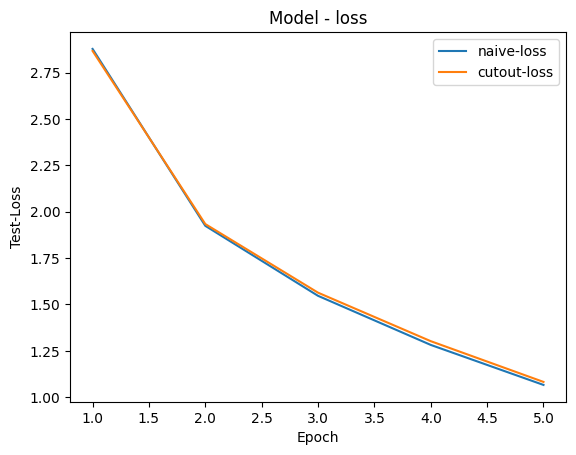

In [40]:
my_plot(np.linspace(1,num_epochs,num_epochs).astype(int),loss_vals,labels='naive-loss')
my_plot(np.linspace(1,num_epochs,num_epochs).astype(int),loss_vals2,labels='cutout-loss')
plt.xlabel('Epoch')
plt.ylabel('Test-Loss')
plt.title('Model - loss')
plt.legend(loc='upper right')
plt.show()

In [21]:
images.shape

torch.Size([16, 3, 32, 32])

In [22]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [23]:
cpu = torch.device('cpu')

In [24]:
images2 = images

In [25]:
images2 = images2.to(cpu)

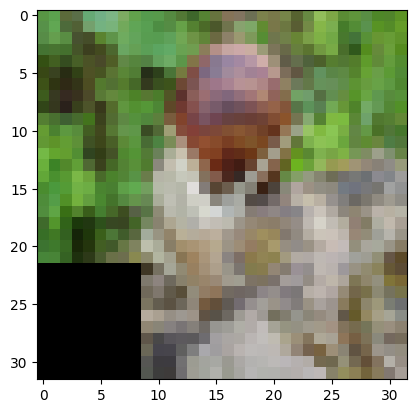

In [51]:
cut = Cutout(1,length=10)
plt.imshow(cut(images2[3]).permute(1, 2, 0)  )

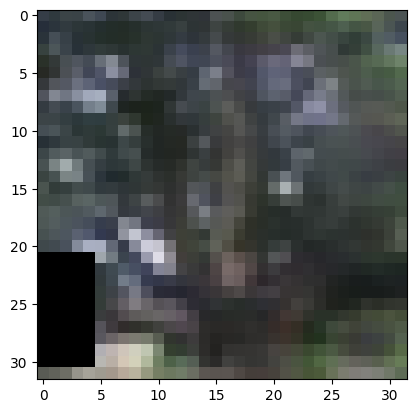

In [52]:
cut = Cutout(1,length=10)
plt.imshow(cut(images2[0]).permute(1, 2, 0)  )

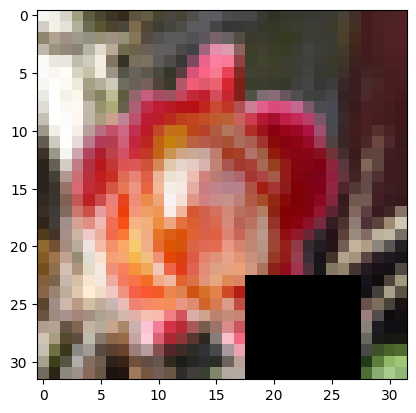

In [53]:
cut = Cutout(1,length=10)
plt.imshow(cut(images2[15]).permute(1, 2, 0)  )